In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from skimage import io

In [2]:
# Understanding data - csv
# image_path = '/media/nicolas/Lenovo/Projects/UnderstandingAmazon/data'

#https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space

#inspiration from
#https://www.kaggle.com/code/robinkraft/getting-started-with-the-data-now-with-docs

In [3]:
train_data = pd.read_csv(os.path.join('data','train_v2.csv'))

In [4]:
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
#so many individual classes
class_num = train_data['tags'].value_counts()
class_num

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

In [6]:
#seems like some tags have duplicated information 
# eg -> agriculture clear cultivation cultivation road has 'cultivation' repetated.
# lets clean that out
train_data['tags_no_dups'] = train_data['tags'].str.split().apply(lambda x:' '.join(set(x)))

In [7]:
weather_labels = {'clear', 'partly_cloudy', 'haze'}

In [8]:
#removing weather labels minus 'cloudy' i want a model to that learns to classify no matter weather conditions


train_data['tags_no_weather'] = train_data['tags_no_dups'].apply(lambda x: ' '.join(set(x.split(' ')).difference(weather_labels)))

In [14]:
#count how many individual classes are in the dataset
from collections import Counter
counter = Counter()
for pic in train_data['tags_no_weather'].str.split():
    counter.update(pic)

In [15]:
class_num = train_data['tags_no_weather'].value_counts()
class_num

primary                                                      18737
agriculture primary                                           2490
agriculture road primary                                      2337
water primary                                                 2164
cloudy                                                        2089
                                                             ...  
habitation agriculture road bare_ground conventional_mine        1
primary habitation agriculture bare_ground cultivation           1
primary agriculture road water bare_ground cultivation           1
primary road selective_logging habitation                        1
primary road selective_logging bare_ground cultivation           1
Name: tags_no_weather, Length: 260, dtype: int64

In [16]:
individual_label = pd.DataFrame(counter.values(),counter.keys()).sort_values(by =0 , ascending = False)
individual_label.rename({0:'count'},axis = 1,inplace = True)
individual_label = individual_label.reset_index()

In [17]:
individual_label.rename({'index':'label'},axis = 1,inplace = True)

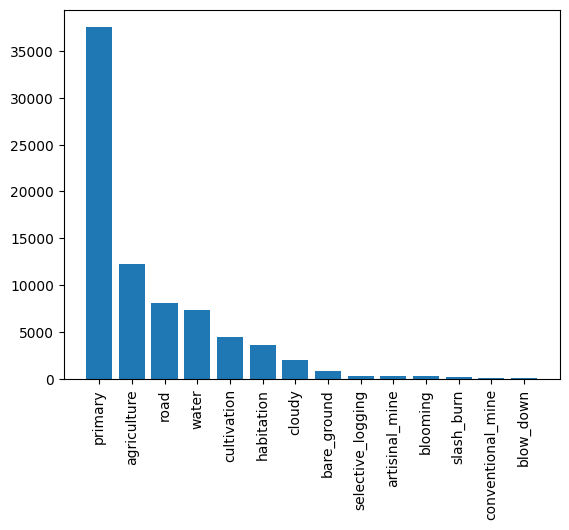

In [18]:
plt.bar(individual_label['label'],individual_label['count'])
plt.xticks(rotation = 90)
plt.show()

In [19]:
individual_label

,label,count
0,primary,37513
1,agriculture,12315
2,road,8071
3,water,7411
4,cultivation,4477
5,habitation,3660
6,cloudy,2089
7,bare_ground,862
8,selective_logging,340
9,artisinal_mine,339


In [20]:
#Chips that are labeled as cloudy should have no other labels, but there may be labeling errors
#correct

In [22]:
train_data[~(train_data['tags_no_weather'].str.contains('partly_cloudy'))&
            (train_data['tags_no_weather'].str.contains('cloudy'))&
            (train_data['tags_no_weather'].str.split().apply(lambda x:len(x)) != 1)]


,image_name,tags,tags_no_dups,tags_no_weather


In [23]:
#tags per image one hot
for tag in individual_label['label']:
    train_data[tag] = train_data['tags_no_weather'].apply(lambda x:1 if tag in x.split() else 0)

In [24]:
train_data.head()

,image_name,tags,tags_no_dups,tags_no_weather,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
0,train_0,haze primary,haze primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,agriculture water primary clear,agriculture water primary,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,primary clear habitation agriculture road,primary road agriculture habitation,1,1,1,0,0,1,0,0,0,0,0,0,0,0


In [27]:
#from notebook
def heatmap_matrix(labels):
    numeric_df = train_data[individual_label['label']][labels]
    matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(matrix,cmap='Blues')
    return matrix

,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
primary,37513,11972,7728,7001,4455,3469,0,683,340,324,332,209,94,98
agriculture,11972,12315,6034,2712,3377,2737,0,225,65,38,32,119,24,22
road,7728,6034,8071,2125,1294,2786,0,323,151,110,10,36,59,2
water,7001,2712,2125,7411,868,915,0,206,49,299,16,24,26,3
cultivation,4455,3377,1294,868,4477,895,0,89,58,18,35,126,4,8
habitation,3469,2737,2786,915,895,3660,0,163,13,29,4,41,36,3
cloudy,0,0,0,0,0,0,2089,0,0,0,0,0,0,0
bare_ground,683,225,323,206,89,163,0,862,13,40,3,10,10,4
selective_logging,340,65,151,49,58,13,0,13,340,6,7,2,0,1
artisinal_mine,324,38,110,299,18,29,0,40,6,339,0,0,4,0


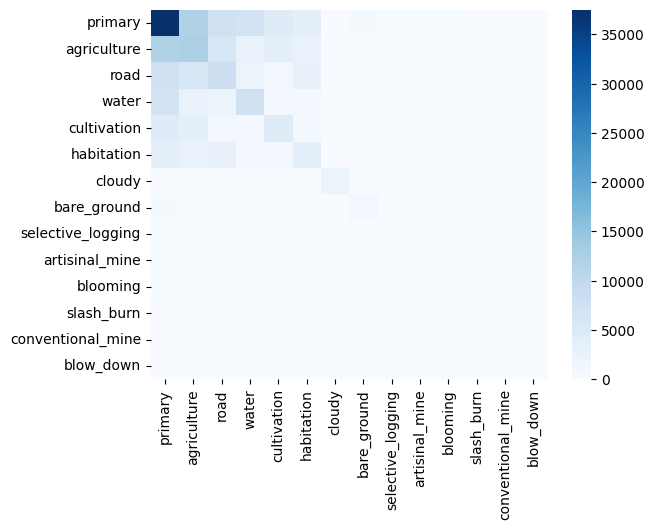

In [28]:
heatmap_matrix(individual_label['label'])

In [29]:
rare_individual = individual_label[individual_label['count'] < 2000]

In [30]:
rare_individual

,label,count
7,bare_ground,862
8,selective_logging,340
9,artisinal_mine,339
10,blooming,332
11,slash_burn,209
12,conventional_mine,100
13,blow_down,98


In [31]:
#Images

In [32]:
#select images to display

In [33]:
top_10_classes = class_num[:10]
last_10_classes = class_num[-10:]

In [34]:
top_10_classes.index

Index(['primary', 'agriculture primary', 'agriculture road primary',
       'water primary', 'cloudy', 'agriculture primary cultivation',
       'primary road agriculture habitation', 'agriculture water primary',
       'primary road water', 'primary road agriculture water'],
      dtype='object')

In [35]:
#first mount disk
image_path = '/media/nicolas/Lenovo/Projects/UnderstandingAmazon/data'
image_jpg_list = os.path.join(image_path,'train-jpg')
image_tiff_list = os.path.join(image_path,'train-tif-v2')

In [39]:
def random_sample(labels,ext):
    images = []
    if ext == '.jpg':
        dirname = image_jpg_list
    else:
        dirname = image_tiff_list
    
    for image in labels.index:
        image_name = train_data[train_data['tags_no_weather']== image].sample(1,random_state=1080)['image_name'].iloc[0] + ext
        img = io.imread(os.path.join(dirname,image_name))
        images.append([image_name,image,img])
    return images

In [40]:
#from notebook in kaggle
def plot_rgbn_histo(image):
    bgr_image = image[:,:,:3]
    rgb_image = image[:, :, [2,1,0]]
    
    b, g, r = bgr_image[:, :, 0], bgr_image[:, :, 1], bgr_image[:, :, 2]
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

In [41]:
images_jpg = random_sample(top_10_classes,'.jpg')
images_tif = random_sample(top_10_classes,'.tif')

In [42]:
images_jpg_last = random_sample(last_10_classes,'.jpg')

In [43]:
images_jpg[0][1],images_tif[0][1]

('primary', 'primary')

In [44]:
sample_image_jpg = images_jpg[0][2]
sample_image_tif = images_tif[0][2]


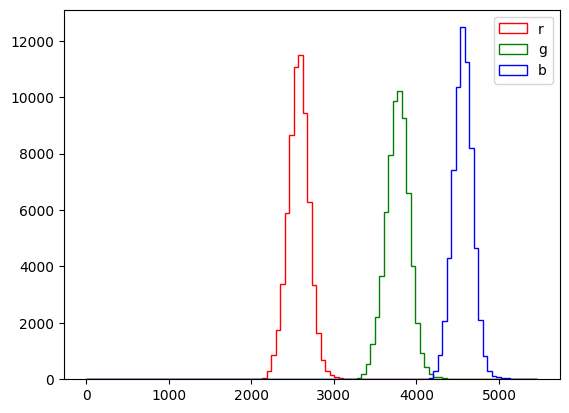

In [45]:
plot_rgbn_histo(sample_image_tif)

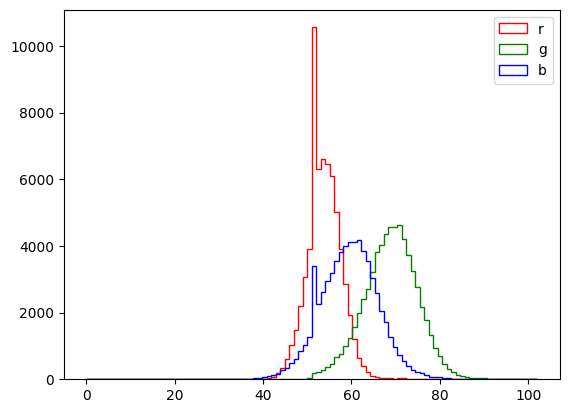

In [46]:
plot_rgbn_histo(sample_image_jpg)

In [47]:
def plot_images(images):
    fig = plt.figure(figsize=(20, 20))
    for i,img in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_title(img[1],fontsize = 8)
        fig.set_figheight(8)
        fig.set_figwidth(28)
        plt.imshow(img[2])
    plt.show()

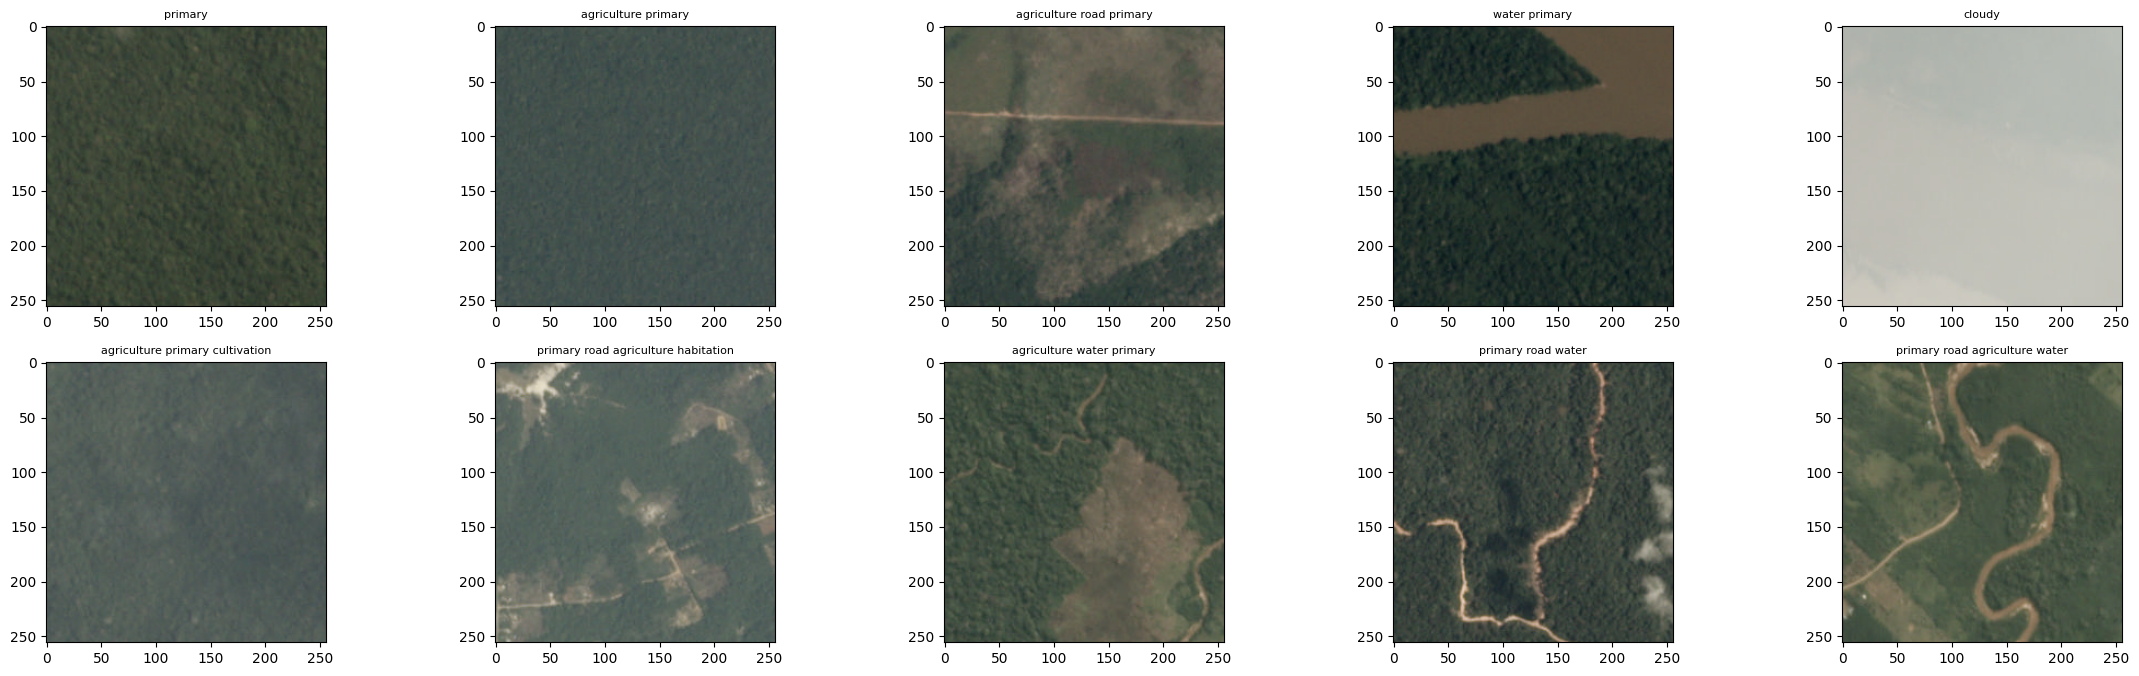

In [48]:
plot_images(images_jpg)

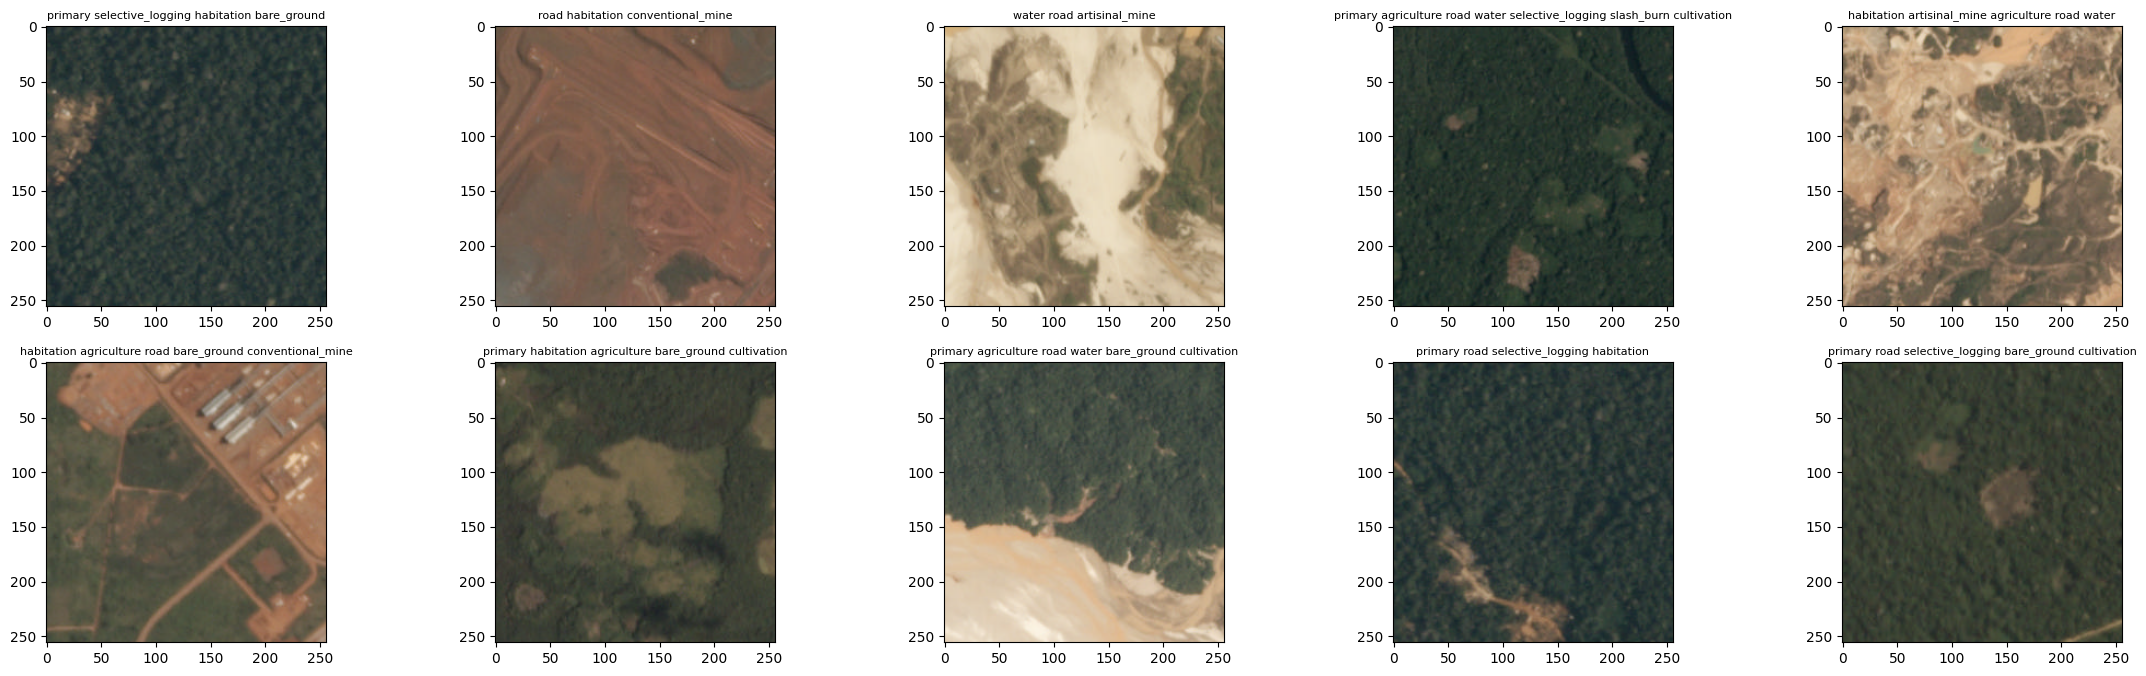

In [49]:
plot_images(images_jpg_last)

# Classes

In [50]:
train_data.head()

,image_name,tags,tags_no_dups,tags_no_weather,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
0,train_0,haze primary,haze primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,agriculture water primary clear,agriculture water primary,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,primary clear habitation agriculture road,primary road agriculture habitation,1,1,1,0,0,1,0,0,0,0,0,0,0,0


In [54]:
class_num[class_num == 1]
#80 classes with one training example

primary water blooming cultivation                           1
bare_ground road habitation artisinal_mine                   1
primary selective_logging cultivation bare_ground            1
primary selective_logging blow_down                          1
primary cultivation habitation blow_down                     1
                                                            ..
habitation agriculture road bare_ground conventional_mine    1
primary habitation agriculture bare_ground cultivation       1
primary agriculture road water bare_ground cultivation       1
primary road selective_logging habitation                    1
primary road selective_logging bare_ground cultivation       1
Name: tags_no_weather, Length: 80, dtype: int64

In [58]:
class_num[class_num > 20]

primary                                                  18737
agriculture primary                                       2490
agriculture road primary                                  2337
water primary                                             2164
cloudy                                                    2089
agriculture primary cultivation                           1572
primary road agriculture habitation                       1328
agriculture water primary                                 1010
primary road water                                         671
primary road agriculture water                             605
primary water                                              595
primary cultivation                                        558
primary road agriculture cultivation                       536
primary road                                               378
primary habitation agriculture road cultivation            349
primary water agriculture cultivation                  